In [1]:
from pandas import DataFrame
from pandas import concat

from math import sqrt
from numpy import concatenate
from numpy import array
from numpy import hstack

from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

#settings for graphics
import numpy as np
import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(17, 6)})


#Divide Dataset intro train and test sets
def split_data(dataset,split):
    n_train_hours = int(len(dataset) * split)
    train=dataset.iloc[:n_train_hours].to_numpy()
    test=dataset.iloc[n_train_hours:].to_numpy()
    print("Total obs: {}, training obs:{}, test obs:{}".format(len(dataset),n_train_hours,len(dataset)-n_train_hours))
    return train,test

# Standarize data based on train set
def scale(train, test):
    #calculation of scaling statistics has to be conducted on training data 
    #and must then be applied to the test data, Otherwise, you use future information at the time of forecasting 
    # which commonly biases forecasting metrics in a positive direction:
    scaler = RobustScaler() # or with minmax feature_range=(-1, 1)
    scaler = scaler.fit(train) # fit scaler
    train_scaled = scaler.transform(train) # transform train
    test_scaled = scaler.transform(test) # transform test
    print("Train and Test set scaled")
    return scaler, train_scaled, test_scaled

# Split a multivariate sequence into samples of the form [Xt-in...Xt0]=[Yt+1...Yt+out]
# target variable must be the last column.
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


#Invert Scaling element
def invert_scale_Xy(scaler, X_sample,Y_sample):
    XY_array=np.hstack((X_sample[-n_steps_out:,:], Y_sample.reshape(Y_sample.shape[0],1)))
    inverted = scaler.inverse_transform(XY_array)
    return inverted[0:, -1]

# MAPE calculation
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Evaluate one or more hourly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    MAE,MSE,RMSE,MAPE = [],[],[],[]
    # calculate an error score for each hour predicted
    for i in range(actual.shape[1]):
        mae= mean_absolute_error(actual[:, i], predicted[:, i])# calculate mae
        MAE.append(mae) # store
        mse = mean_squared_error(actual[:, i], predicted[:, i])# calculate mse
        MSE.append(mse)
        rmse = sqrt(mse)# calculate rmse
        RMSE.append(rmse) # store
        mape=mean_absolute_percentage_error(actual[:, i], predicted[:, i])
        MAPE.append(mape)
    scores=pd.DataFrame(list(zip(MAE,RMSE,MAPE)),columns=['MAE','RMSE','MAPE'])
    scores.index = ['t+'+str(i) for i in range(1,len(scores)+1)]
    scores.loc['mean'] = scores.mean()
    return scores


import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR) # ignore warnings from tensorflow

import os
import pandas as pd
directory = os.getcwd()
os.chdir(os.path.abspath(os.path.join(directory, os.pardir)))# change dir to parent folder

Using TensorFlow backend.


In [2]:
# 0 # LOAD  DATASET:
df=pd.read_excel(os.getcwd()+"\Data Preparation\dataset.xlsx",sep=';',index_col=0)#,usecols=range(0,9))
#df=df[df.columns[list(range(1,8))+[0]]]
os.chdir(directory)
print("NaN tweet rows: ",len(df)-df['X.tweets'].dropna().count())
print("from {} , equivalent to {}% of total data dropped".format(len(df),round(100*(len(df)-df['X.tweets'].dropna().count())/len(df),2)))
df=df.dropna()

print(len(df))
df.head()

NaN tweet rows:  786
from 18757 , equivalent to 4.19% of total data dropped
17883


,Close,Volume.BTC,Volume.USD,Gtrends,X.tweets,AdrActCnt,TxTfrValMeanUSD,NVTAdj90,RSI,TRIX,MACDhist
Datetime,,,,,,,,,,,
2017-07-05 03:00:00,2550.96,550.75,1408018.24,3.672459,454.0,649605.0,9048.309937,32.841126,42.043947,0.097154,-6.586065
2017-07-05 04:00:00,2535.35,638.17,1620776.27,3.591746,486.0,649605.0,9048.309937,32.841126,38.161506,0.093222,-7.498749
2017-07-05 05:00:00,2560.22,490.48,1249478.44,3.470675,447.0,649605.0,9048.309937,32.841126,46.619068,0.089275,-6.108594
2017-07-05 06:00:00,2547.65,190.61,486318.59,3.511032,426.0,649605.0,9048.309937,32.841126,43.389010,0.085208,-5.723350
2017-07-05 07:00:00,2538.11,407.90,1035958.79,3.349605,448.0,649605.0,9048.309937,32.841126,41.063591,0.080966,-5.781747


In [3]:
Basic_DS=df[['Volume.BTC','Volume.USD','Close']]
Basic_DS.name='Basic_DS'

Social_DS=df[['Volume.BTC','Volume.USD','Gtrends','X.tweets','Close']]  #Social(5)
Social_DS.name='Social_DS'

Fundamental_DS=df[['AdrActCnt','TxTfrValMeanUSD','NVTAdj90','Volume.USD','Volume.BTC','Close']] #daily Fundamentals(6)
Fundamental_DS.name='Fund_DS'

Technical_DS=df[['RSI', 'TRIX', 'MACDhist','Volume.USD','Volume.BTC','Close']] #Technical(6)
Technical_DS.name='Tech_DS'

Ranked_DS=df[['Volume.USD','Volume.BTC','Gtrends','X.tweets','NVTAdj90','TxTfrValMeanUSD','Close']] #Best_ranked(7)
Ranked_DS.name='Ranked_DS'

Datasets=[Basic_DS,Social_DS,Fundamental_DS,Technical_DS,Ranked_DS]

In [4]:
# 1 # PREPARE DATA FOR LSTM:
def Prepare_for_LSTM(DS,Split,N_in,N_out):
    train,test=split_data(DS,Split) #Split train and test
    scaler, train_scaled, test_scaled=scale(train,test) #Standarize/Scale
    # Reframe to supervised learning [samples,time_steps,features]:
    X_train,y_train=split_sequences(train_scaled,N_in,N_out)
    X_test,y_test=split_sequences(test_scaled,N_in,N_out)
    print("Train reframed to X:{} and y:{}".format(X_train.shape,y_train.shape))
    print("Test reframed to X:{} and y:{}".format(X_test.shape,y_test.shape))
    return X_train,y_train,X_test,y_test,scaler

In [5]:
# 2 # Build and SET Models (VECTOR OUTPUT)
#     define model Stacked LTSM 3 layer output vector for multistep forecast:
def Set_Model_vector_output(neurons,dropout,epochs,batch_size,X_train,y_train):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train.shape[1],X_train.shape[2]),return_sequences=True))
    model.add(Dropout(dropout))# 1st LSTM layer with dropout regularization.
    model.add(LSTM(units = neurons, return_sequences = False))
    model.add(Dropout(dropout))# 2nd LSTM layer with dropout regularization.
    model.add(Dense(y_train.shape[1]))#Output layer
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    return model

In [6]:
# Dataset Parameters:
Split = 0.8      # Training Data portion
n_steps_in = 12  # number of timesteps as input
n_steps_out = 12  # number of timesteps as output (vector lenght)
# Common  training parameters:
verbose = 1  # print or not Fit process
epochs = 120 # max number of epochs
patience = 11 # Early stoping point check

#Chosen hyperparameters, found after some trials that are not published within this repository:
neurons=50
drop=0.2
batch_size=64

Models=[]
Histories=[]

for data in Datasets:
    print('\n Number of columns: ',len(data.columns))
    X_train,y_train,X_test,y_test,scaler=Prepare_for_LSTM(data,Split,n_steps_in,n_steps_out)
    
    #y_train_reshaped = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
    #y_test_reshaped = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))
    
    
    model=Set_Model_vector_output(neurons,drop,epochs,batch_size,X_train,y_train)
    Models.append(model)
    # train/fit model
    es = EarlyStopping(monitor='val_loss', verbose=1,patience=patience,restore_best_weights=True) #early stop if loss starts to increase
    mc = ModelCheckpoint('2layers'+data.name+'.h5', monitor='val_loss', verbose=1,save_best_only=True)
    history=model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2,validation_data=(X_test, y_test),shuffle=False, callbacks=[es],mc])
    Histories.append(history)



 Number of columns:  3
Total obs: 17883, training obs:14306, test obs:3577
Train and Test set scaled
Train reframed to X:(14284, 12, 2) and y:(14284, 12)
Test reframed to X:(3555, 12, 2) and y:(3555, 12)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 55)            12760     
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 55)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 55)                24420     
_________________________________________________________________
dropout_2 (Dropout)          (None, 55)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                672       
Total params: 37,852
Trainable params: 37,852
Non-trainable params: 0

 - 11s - loss: 0.0208 - val_loss: 0.0305
Epoch 19/120
 - 11s - loss: 0.0387 - val_loss: 0.0526
Epoch 20/120
 - 11s - loss: 0.0544 - val_loss: 0.0579
Epoch 21/120
 - 11s - loss: 0.0390 - val_loss: 0.0565
Epoch 22/120
 - 11s - loss: 0.0285 - val_loss: 0.0487
Epoch 23/120
 - 11s - loss: 0.0269 - val_loss: 0.0318
Epoch 24/120
 - 11s - loss: 0.0261 - val_loss: 0.0223
Epoch 25/120
 - 11s - loss: 0.0260 - val_loss: 0.0190
Epoch 26/120
 - 11s - loss: 0.0188 - val_loss: 0.0161
Epoch 27/120
 - 11s - loss: 0.0156 - val_loss: 0.0155
Epoch 28/120
 - 15s - loss: 0.0165 - val_loss: 0.0157
Epoch 29/120
 - 13s - loss: 0.0264 - val_loss: 0.0447
Epoch 30/120
 - 11s - loss: 0.0268 - val_loss: 0.0323
Epoch 31/120
 - 11s - loss: 0.0202 - val_loss: 0.0283
Epoch 32/120
 - 11s - loss: 0.0192 - val_loss: 0.0234
Epoch 33/120
 - 11s - loss: 0.0172 - val_loss: 0.0179
Epoch 34/120
 - 11s - loss: 0.0152 - val_loss: 0.0150
Epoch 35/120
 - 11s - loss: 0.0140 - val_loss: 0.0142
Epoch 36/120
 - 10s - loss: 0.0229 - val_

 - 11s - loss: 0.3692 - val_loss: 0.5560
Epoch 2/120
 - 5s - loss: 0.2171 - val_loss: 0.3420
Epoch 3/120
 - 5s - loss: 0.1745 - val_loss: 0.2634
Epoch 4/120
 - 7s - loss: 0.1449 - val_loss: 0.2254
Epoch 5/120
 - 7s - loss: 0.1307 - val_loss: 0.1960
Epoch 6/120
 - 10s - loss: 0.1172 - val_loss: 0.1880
Epoch 7/120
 - 10s - loss: 0.1088 - val_loss: 0.1906
Epoch 8/120
 - 10s - loss: 0.0993 - val_loss: 0.1774
Epoch 9/120
 - 10s - loss: 0.0918 - val_loss: 0.1791
Epoch 10/120
 - 10s - loss: 0.0838 - val_loss: 0.1720
Epoch 11/120
 - 9s - loss: 0.0724 - val_loss: 0.1585
Epoch 12/120
 - 10s - loss: 0.0634 - val_loss: 0.1262
Epoch 13/120
 - 10s - loss: 0.0447 - val_loss: 0.0965
Epoch 14/120
 - 10s - loss: 0.0361 - val_loss: 0.0754
Epoch 15/120
 - 10s - loss: 0.0263 - val_loss: 0.0524
Epoch 16/120
 - 10s - loss: 0.0227 - val_loss: 0.0396
Epoch 17/120
 - 10s - loss: 0.0208 - val_loss: 0.0357
Epoch 18/120
 - 11s - loss: 0.0216 - val_loss: 0.0355
Epoch 19/120
 - 13s - loss: 0.0245 - val_loss: 0.0434


Epoch 33/120
 - 6s - loss: 0.0196 - val_loss: 0.0163
Epoch 34/120
 - 6s - loss: 0.0214 - val_loss: 0.0149
Epoch 35/120
 - 5s - loss: 0.0216 - val_loss: 0.0190
Epoch 36/120
 - 5s - loss: 0.0194 - val_loss: 0.0178
Epoch 37/120
 - 5s - loss: 0.0149 - val_loss: 0.0150
Epoch 38/120
 - 5s - loss: 0.0228 - val_loss: 0.0114
Epoch 39/120
 - 5s - loss: 0.0160 - val_loss: 0.0130
Epoch 40/120
 - 5s - loss: 0.0171 - val_loss: 0.0079
Epoch 41/120
 - 5s - loss: 0.0172 - val_loss: 0.0070
Epoch 42/120
 - 5s - loss: 0.0146 - val_loss: 0.0062
Epoch 43/120
 - 5s - loss: 0.0151 - val_loss: 0.0070
Epoch 44/120
 - 5s - loss: 0.0150 - val_loss: 0.0056
Epoch 45/120
 - 5s - loss: 0.0194 - val_loss: 0.0110
Epoch 46/120
 - 5s - loss: 0.0160 - val_loss: 0.0078
Epoch 47/120
 - 6s - loss: 0.0276 - val_loss: 0.0162
Epoch 48/120
 - 5s - loss: 0.0398 - val_loss: 0.0225
Epoch 49/120
 - 5s - loss: 0.0308 - val_loss: 0.0353
Epoch 50/120
 - 5s - loss: 0.0208 - val_loss: 0.0186
Epoch 51/120
 - 5s - loss: 0.0163 - val_loss: 

In [7]:
RESULTS=[]
Originals=[]
SCORES=[]
for i in range(len(Models)):
        
    X_train,y_train,X_test,y_test,scaler=Prepare_for_LSTM(Datasets[i],Split,n_steps_in,n_steps_out)
    Y_predicted=Models[i].predict(X_test)
    
    Y_rescaled=[]
    for j in range(len(Y_predicted)):
        Y_rescaled.append(invert_scale_Xy(scaler,np.vstack((X_test[j],X_test[j])),Y_predicted[j]))
    Y_predicted=array(Y_rescaled)
    RESULTS.append(Y_predicted)
    
    Y_rescaled=[]
    for k in range(len(Y_predicted)):
        Y_rescaled.append(invert_scale_Xy(scaler,np.vstack((X_test[k],X_test[k])),y_test[k]))
    Y_orig=array(Y_rescaled)
    Originals.append(Y_orig)
    
    score=evaluate_forecasts(Y_orig,Y_predicted)
    SCORES.append(score)

Total obs: 17883, training obs:14306, test obs:3577
Train and Test set scaled
Train reframed to X:(14284, 12, 2) and y:(14284, 12)
Test reframed to X:(3555, 12, 2) and y:(3555, 12)
Total obs: 17883, training obs:14306, test obs:3577
Train and Test set scaled
Train reframed to X:(14284, 12, 4) and y:(14284, 12)
Test reframed to X:(3555, 12, 4) and y:(3555, 12)
Total obs: 17883, training obs:14306, test obs:3577
Train and Test set scaled
Train reframed to X:(14284, 12, 5) and y:(14284, 12)
Test reframed to X:(3555, 12, 5) and y:(3555, 12)
Total obs: 17883, training obs:14306, test obs:3577
Train and Test set scaled
Train reframed to X:(14284, 12, 5) and y:(14284, 12)
Test reframed to X:(3555, 12, 5) and y:(3555, 12)
Total obs: 17883, training obs:14306, test obs:3577
Train and Test set scaled
Train reframed to X:(14284, 12, 6) and y:(14284, 12)
Test reframed to X:(3555, 12, 6) and y:(3555, 12)


In [8]:
[print('\n'+Datasets[i].name+'\n', SCORES[i]) for i in range(len(SCORES))]


Basic_DS
              MAE        RMSE      MAPE
t+1   250.461205  311.787314  3.140390
t+2   255.429888  319.531407  3.208985
t+3   263.166052  330.440387  3.312507
t+4   271.685113  341.827215  3.418004
t+5   276.645038  350.414675  3.462437
t+6   281.562392  358.939810  3.511777
t+7   289.639620  369.917377  3.603987
t+8   293.561516  376.335018  3.657706
t+9   300.922051  387.053100  3.734986
t+10  302.056912  390.803479  3.749319
t+11  308.452894  400.002815  3.817184
t+12  312.730654  407.522009  3.862489
mean  283.859445  362.047884  3.539981

Social_DS
              MAE        RMSE      MAPE
t+1   180.154631  263.514825  2.325831
t+2   191.952744  277.007378  2.458574
t+3   197.682475  285.610097  2.516873
t+4   203.832801  293.905473  2.585061
t+5   214.429287  308.122282  2.699195
t+6   223.239285  317.096555  2.805308
t+7   230.787425  327.122590  2.872575
t+8   239.057542  338.473126  2.964723
t+9   246.271347  344.770356  3.044794
t+10  257.138472  356.707003  3.163618
t+

[None, None, None, None, None]

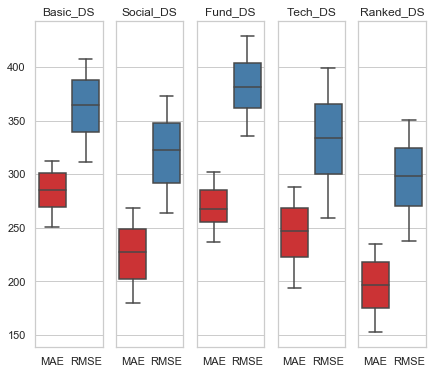

In [26]:
sns.set(style="whitegrid",palette="Set1")#,rc={'figure.figsize':(3, 3)})
f, axes = plt.subplots(1,len(SCORES) , figsize=(7, 6), sharex=False,sharey=True)
for H in range(len(SCORES)):
    sns.boxplot(data=SCORES[H][['MAE','RMSE']][:-1],ax=axes[H]).set_title(str(Datasets[H].name))

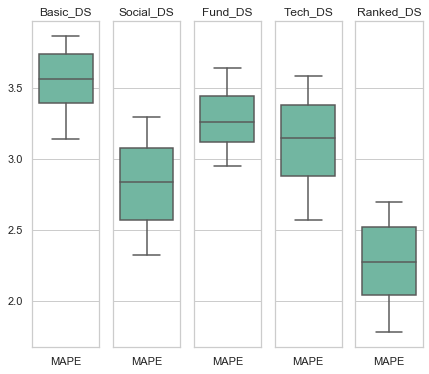

In [27]:
sns.set(style="whitegrid",palette="Set2")#,rc={'figure.figsize':(3, 3)})
f, axes = plt.subplots(1, len(SCORES), figsize=(7, 6), sharex=False,sharey=True)
for H in range(len(SCORES)):
    sns.boxplot(data=SCORES[H][['MAPE']][:-1],ax=axes[H]).set_title(str(Datasets[H].name))

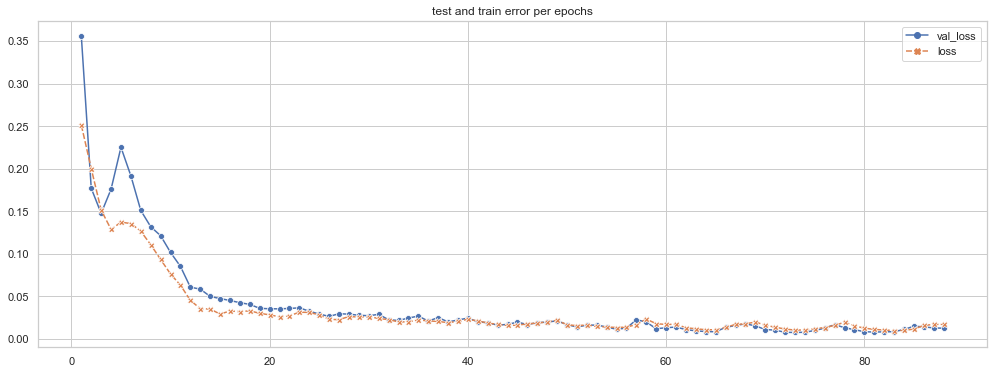

In [11]:
sns.set(rc={'figure.figsize':(17, 6)})
Data=pd.DataFrame(Histories[0].history,index=range(1,len(Histories[0].history['loss'])+1))
with sns.axes_style("whitegrid"):
    ax=sns.lineplot(data=Data,markers=True).set_title('test and train error per epochs')
# train and test performance while building the model for the Basic_DS

Text(0.5, 1.0, 'True vs Ranked_DS forecast of  Vector output model')

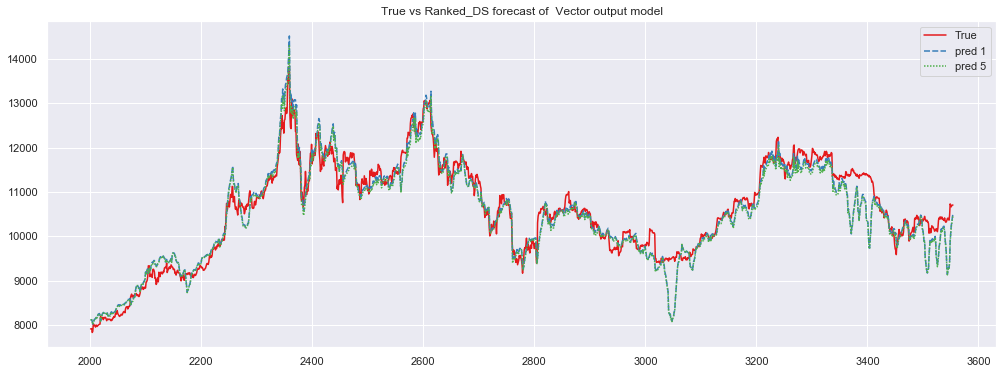

In [33]:
sns.set(rc={'figure.figsize':(17, 6)},palette="Set1")
cols=['True']+['pred '+str(i) for i in range(1,n_steps_out+1)]
Data=pd.DataFrame(np.hstack((Originals[0][:,0].reshape(Originals[0][:,0].shape[0],1),RESULTS[4])),columns=cols)
sns.lineplot(data=Data[['True','pred 1','pred 5']][Data.index>2000]).set_title('True vs Ranked_DS forecast of  Vector output model')

In [19]:
Predictions=[str(Df[Df['RMSE']==Df['RMSE'].min()].index.values).replace("['t+",'pred ').replace("']","") for Df in SCORES]
B_COL=[int(str(Df[Df['RMSE']==Df['RMSE'].min()].index.values).replace("['t+",'').replace("']",""))-1 for Df in SCORES]
cols=['True price']+[Datasets[i].name+' Forecast' for  i in range(len(Datasets))]
cols

['True price',
 'Basic_DS Forecast',
 'Social_DS Forecast',
 'Fund_DS Forecast',
 'Tech_DS Forecast',
 'Ranked_DS Forecast']

In [20]:
#np.hstack((Originals[2][:,0].reshape(Originals[2][:,0].shape[0],1),Predictions[2]))
Predictions # best prediction of each subset

['pred 1', 'pred 1', 'pred 1', 'pred 1', 'pred 1']

Text(0.5, 1.0, 'True vs Best predicted VECTOR OUTPUT 2 layers"')

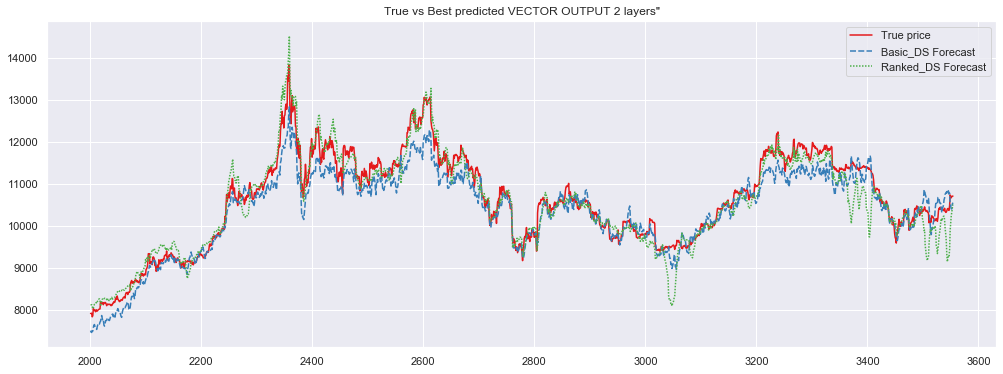

In [28]:
Y_true=Originals[0]
Data=pd.DataFrame(np.hstack((Y_true[:,0].reshape(Y_true[:,0].shape[0],1),array([RESULTS[d][:,B_COL[d]] for d in range(len(Datasets))]).transpose() )),columns=cols)
sns.set(rc={'figure.figsize':(17, 6)},palette="Set1")
sns.lineplot(data=Data[['True price','Basic_DS Forecast','Ranked_DS Forecast']][Data.index>2000],palette='Set1').set_title('True vs Best predicted VECTOR OUTPUT 2 layers"')

In [ ]:
#After a forecasting model has been fit, it is important to assess how well it captures patterns. 
#In other words, evaluating whether the model properly fits the timeseries through their residuals:
#       residual error = expected values – forecasted values
#Residual errors are expected to behave as white noise, as they represent what cannot be captured by the model, by means of the following properties:
#The residuals are uncorrelated. (Acf=0) If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
#The residuals have a mean equal to zero. If the residuals have a mean other than zero, then the forecasts are biased.

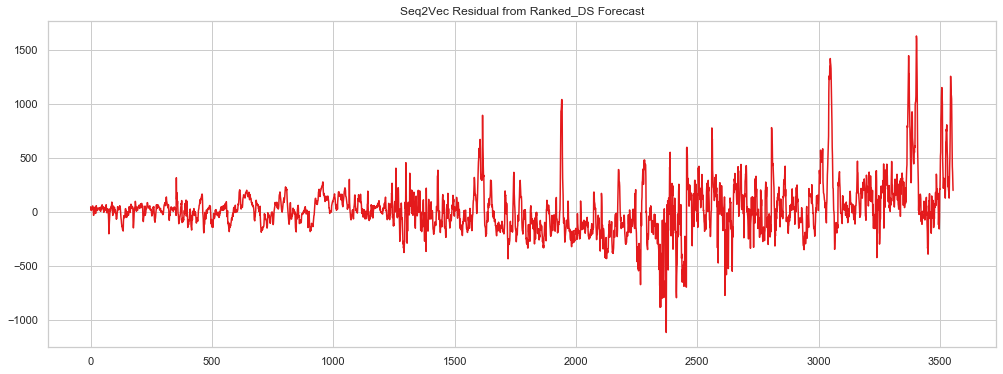

In [22]:
residual = Data['True price']-Data['Ranked_DS Forecast']
with sns.axes_style("whitegrid"):
    ax=sns.lineplot(data=residual).set_title('Seq2Vec Residual from Ranked_DS Forecast')

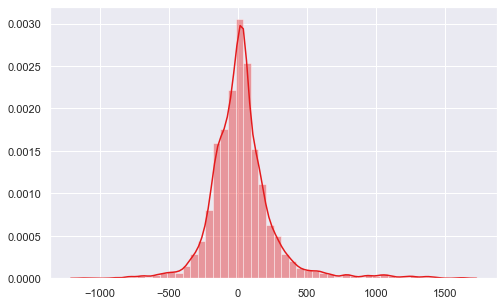

In [25]:
fig, ax = pyplot.subplots(figsize=(8, 5))
sns.distplot(residual,ax=ax);

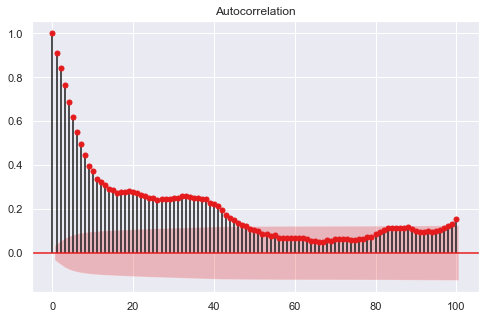

In [24]:
import statsmodels.api as sm
fig, ax = pyplot.subplots(figsize=(8, 5))
sm.graphics.tsa.plot_acf(residual.values.squeeze(), lags=100,ax=ax)
plt.show()